<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [ ]:
# if local
# !conda activate cs685

In [ ]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [ ]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [ ]:
# !git status

install requirements from repo 

In [ ]:
# for colab, use venv if in local
!pip install -r requirements.txt

     |████████████████████████████████| 4.2 MB 15.2 MB/s 
     |████████████████████████████████| 1.8 MB 50.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.4 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 61.7 MB/s 
     |████████████████████████████████| 145 kB 49.4 MB/s 
     |████████████████████████████████| 181 kB 74.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=87502188c80ad487bc5993fe84af693fb543b53aa4bc2cfbd40bee422eb5b70f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


load the helper and dataloader files

In [ ]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [ ]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [ ]:
import os

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [ ]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [ ]:
# Stage 1 Annotations: see config.py for dataset specs
implicit_hate_dataset = Stage1Dataset(dataset_filename["stage-1"], drop_explicit_hate=True)

dataset_size = len(implicit_hate_dataset)
dataset_splits = [int(0.6*dataset_size), int(0.2*dataset_size), dataset_size - int(0.6*dataset_size) - int(0.2*dataset_size)]

# # Smaller dataset for testing model
# dataset_splits = [int(0.006*dataset_size), int(0.002*dataset_size), int(0.002*dataset_size)]
print("Dataset size", dataset_size)
print("Dataset splits", dataset_splits)

train_set, val_set, test_set = torch.utils.data.random_split(implicit_hate_dataset, dataset_splits)

train_dataloader =  DataLoader(train_set, batch_size=8, shuffle=False)
validation_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

# assert len(train_set) == int(0.6*dataset_size)
# assert len(val_set) == int(0.2*dataset_size)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Dataset size 20391
Dataset splits [12234, 4078, 4079]


In [ ]:
# Confirming type is tensor
_, _, input_ids, attention_masks, labels = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_set, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    validation_dataloader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=True)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[2]
      input_mask_tensors = batch[3]
      label_tensors = batch[4]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        # print("outputs", outputs)
        # print("logits", logits)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        # print("pred_flat", pred_flat.shape, pred_flat)
        # print("labels_flat", labels_flat.shape, labels_flat)
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    final_score = precision_recall_fscore_support(predicted, labels)
    class_names=['not_hate', 'implicit_hate']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [ ]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_implicit_hate_vs_non_hate",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5, 4e-5]
        },
        "random_seed" : {
          "values": [37, 69, 42]    
        },

        "epochs" : {
            "values" : [4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: oi0lwpve
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/oi0lwpve


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader =  DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[2]
                input_mask_tensors = batch[3]
                label_tensors = batch[4]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                
                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_set, config, epoch_i, "val")
            
            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'implicit_hate_detection_implicit_hate_vs_non_hate.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_set, config, 0, "test")
        # print(test_precision, test_recall, test_f1)
        # print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: 2ck5edmy with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 803.3923276811838


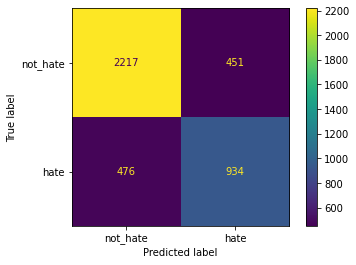

[0.83095952 0.66241135] [0.82324545 0.67436823] [0.8270845  0.66833631]
Validation accuracy: 0.7726826875919568

======== Epoch 2 / 4 ========
Training...
Total loss: 590.2230664007366


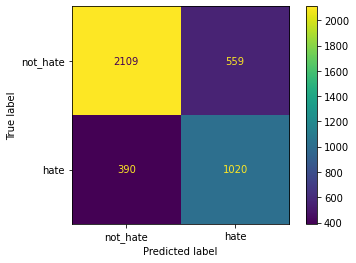

[0.79047976 0.72340426] [0.84393758 0.64597847] [0.81633443 0.68250251]
Validation accuracy: 0.7672878862187347

======== Epoch 3 / 4 ========
Training...
Total loss: 404.83240018785


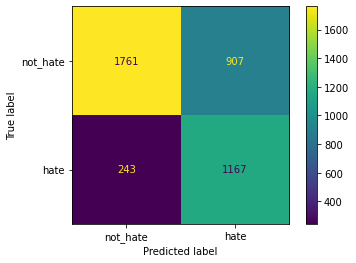

[0.66004498 0.82765957] [0.87874251 0.56268081] [0.75385274 0.66991963]
Validation accuracy: 0.717999019127023

======== Epoch 4 / 4 ========
Training...
Total loss: 252.3877303013578


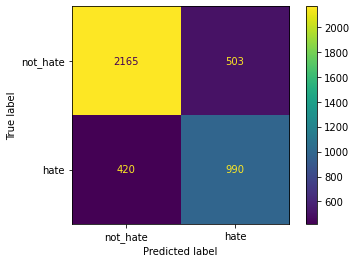

[0.81146927 0.70212766] [0.83752418 0.66309444] [0.82429088 0.68205305]
Validation accuracy: 0.7736635605689063

Training complete!


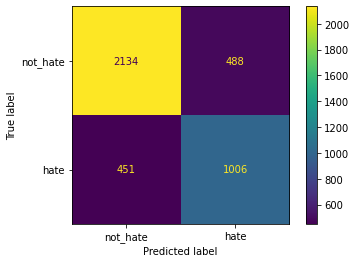

Test accuracy: 0.7697965187545968


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▅▆▄▅▄▄▅▃▅▄█▃▄▄▃▃▄▄▄▄▂▂▄▆▃▄▄▄▁▃▁▁▁▂▄▁▁▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,█▇▁█
batch,1529
batch_loss,0.00502
best_lr,1e-05
best_randomseed,37
best_val,0.77366


wandb: Agent Starting Run: x58lv4hm with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 788.8612956553698


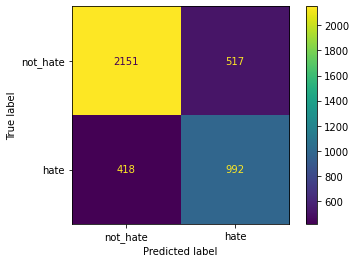

[0.80622189 0.7035461 ] [0.83729077 0.657389  ] [0.82146267 0.67968482]
Validation accuracy: 0.7707209416380578

======== Epoch 2 / 4 ========
Training...
Total loss: 551.5904314853251


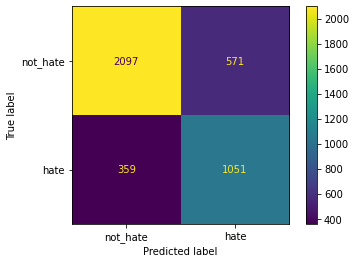

[0.78598201 0.74539007] [0.85382736 0.64796547] [0.81850117 0.69327177]
Validation accuracy: 0.7719470328592447

======== Epoch 3 / 4 ========
Training...
Total loss: 338.7349759442732


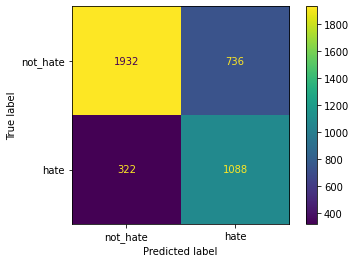

[0.72413793 0.77163121] [0.85714286 0.59649123] [0.78504673 0.67285096]
Validation accuracy: 0.7405590975968612

======== Epoch 4 / 4 ========
Training...
Total loss: 192.8639427679591


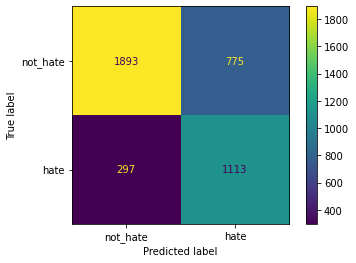

[0.70952024 0.7893617 ] [0.86438356 0.58951271] [0.77933306 0.67495452]
Validation accuracy: 0.737126042177538

Training complete!


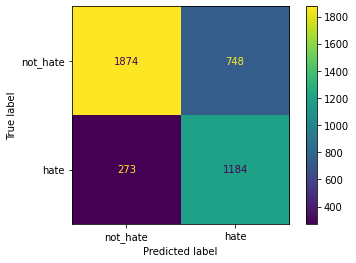

Test accuracy: 0.7496935523412601


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▅▆▄▆▄▄▅▃▆▄▇▂▆▃▂▂▅▄▄▄▂▂▃▅█▃▄▃▂▂▁▁▂▁▁▁▁▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,██▂▁
batch,1529
batch_loss,0.01454
best_lr,1e-05
best_randomseed,69
best_val,0.77195


wandb: Agent Starting Run: nv173rsk with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 798.3558105900884


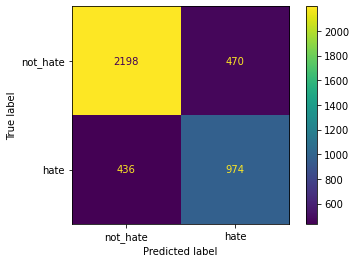

[0.82383808 0.69078014] [0.83447229 0.67451524] [0.82912109 0.68255081]
Validation accuracy: 0.7778322707209416

======== Epoch 2 / 4 ========
Training...
Total loss: 566.4591279998422


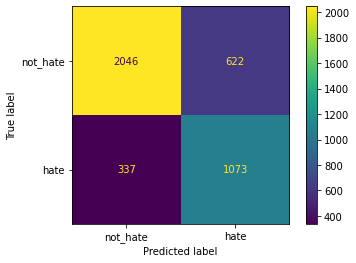

[0.76686657 0.76099291] [0.85858162 0.63303835] [0.81013661 0.69114332]
Validation accuracy: 0.764835703776361

======== Epoch 3 / 4 ========
Training...
Total loss: 374.4488879805431


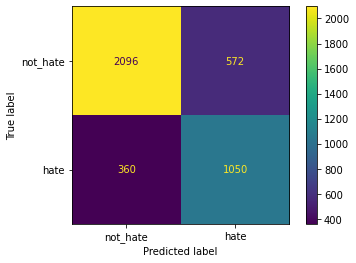

[0.7856072  0.74468085] [0.8534202  0.64734895] [0.81811085 0.69261214]
Validation accuracy: 0.77145659637077

======== Epoch 4 / 4 ========
Training...
Total loss: 237.14688131725416


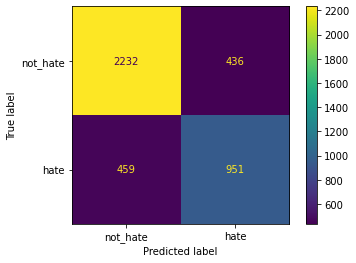

[0.83658171 0.67446809] [0.82943144 0.68565249] [0.83299123 0.6800143 ]
Validation accuracy: 0.7805296714075527

Training complete!


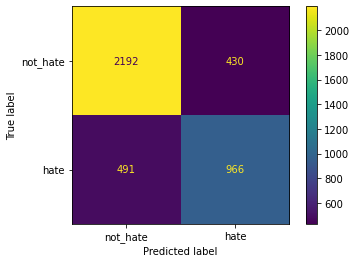

Test accuracy: 0.7742093650404511


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▅▆▅▆▄▅▄▃▆▄▇▃▄▄▂▃▅▅▄▃▁▂▅▆▅▅▂▃▂▄▁▁▁▂▃▁▁▅▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,▇▁▄█
batch,1529
batch_loss,0.0046
best_lr,1e-05
best_randomseed,42
best_val,0.78053


wandb: Agent Starting Run: 64fggtz6 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 798.137107513845


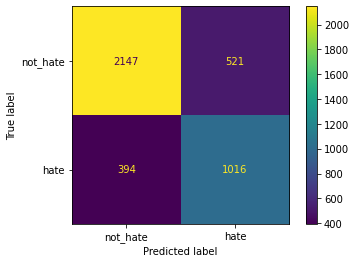

[0.80472264 0.72056738] [0.84494294 0.66102798] [0.82434248 0.68951476]
Validation accuracy: 0.7756253065228053

======== Epoch 2 / 4 ========
Training...
Total loss: 538.2044430226088


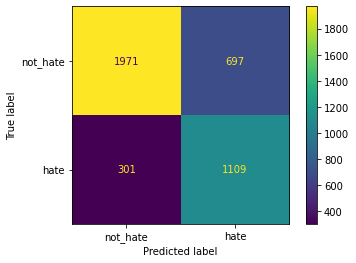

[0.73875562 0.78652482] [0.86751761 0.61406423] [0.79797571 0.68967662]
Validation accuracy: 0.7552721922511035

======== Epoch 3 / 4 ========
Training...
Total loss: 301.45178578444757


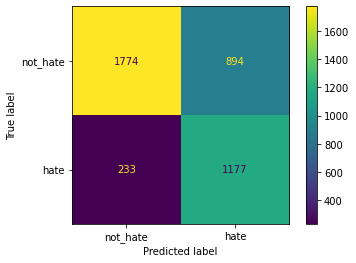

[0.66491754 0.83475177] [0.88390633 0.56832448] [0.75893048 0.67624246]
Validation accuracy: 0.7236390387444825

======== Epoch 4 / 4 ========
Training...
Total loss: 179.8233829003293


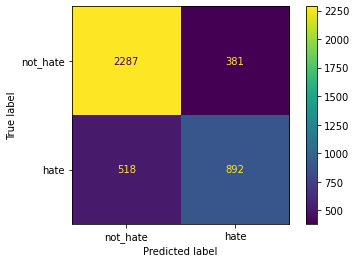

[0.8571964  0.63262411] [0.81532977 0.70070699] [0.83573908 0.66492732]
Validation accuracy: 0.7795487984306032

Training complete!


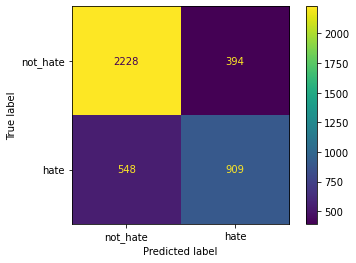

Test accuracy: 0.769061044373621


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▅▇▄▅▄▄▄▂▅▄▇▃█▄▂▃▅▅▄▄▁█▂▃▃▃▅▁▁▂▁▁▁▁▂▁▁▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
val_acc,█▅▁█
batch,1529
batch_loss,0.01586
best_lr,2e-05
best_randomseed,37
best_val,0.77955


wandb: Agent Starting Run: fsygia1p with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 776.9764948785305


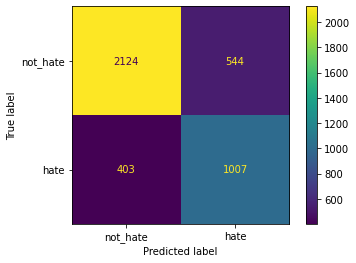

[0.79610195 0.7141844 ] [0.84052236 0.64925854] [0.81770934 0.68017562]
Validation accuracy: 0.7677783227072095

======== Epoch 2 / 4 ========
Training...
Total loss: 524.1514756865799


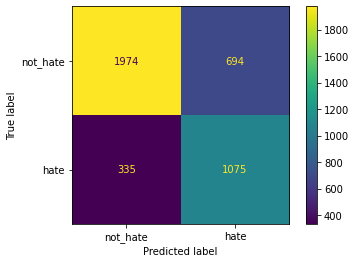

[0.73988006 0.76241135] [0.85491555 0.60768796] [0.79324895 0.67631331]
Validation accuracy: 0.7476704266797449

======== Epoch 3 / 4 ========
Training...
Total loss: 301.68946652812883


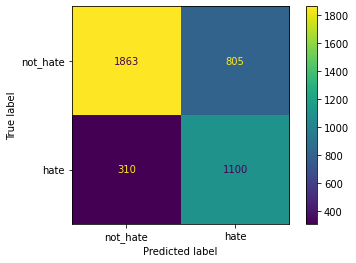

[0.69827586 0.78014184] [0.85734008 0.57742782] [0.76967569 0.66365008]
Validation accuracy: 0.726581657675331

======== Epoch 4 / 4 ========
Training...
Total loss: 183.46784958557691


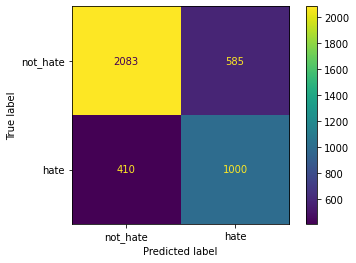

[0.78073463 0.70921986] [0.83553951 0.63091483] [0.80720791 0.66777963]
Validation accuracy: 0.7560078469838156

Training complete!


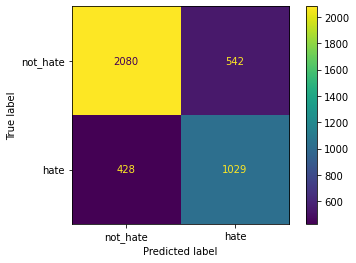

Test accuracy: 0.7621966168178476


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▆▅▄▅▄▄▄▃▆▄▇▂▅▃▂▂▄▃▃▄▁▁▂▃▅▅▃▂▁▂▁▁▁▂▇▁▃▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
val_acc,█▅▁▆
batch,1529
batch_loss,0.0062
best_lr,2e-05
best_randomseed,69
best_val,0.76778


wandb: Agent Starting Run: h1ihq1l5 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 767.2686095833778


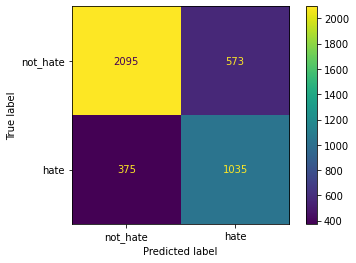

[0.78523238 0.73404255] [0.84817814 0.64365672] [0.81549241 0.68588469]
Validation accuracy: 0.7675331044629721

======== Epoch 2 / 4 ========
Training...
Total loss: 529.3561588963494


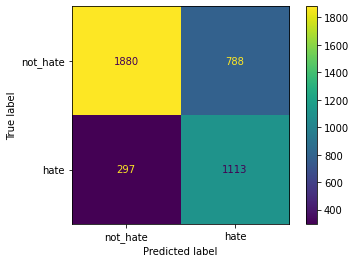

[0.70464768 0.7893617 ] [0.86357373 0.58548133] [0.77605779 0.67230444]
Validation accuracy: 0.7339382050024522

======== Epoch 3 / 4 ========
Training...
Total loss: 303.9086243242491


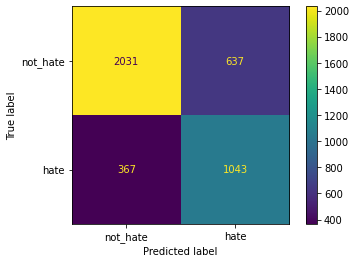

[0.76124438 0.73971631] [0.8469558  0.62083333] [0.80181603 0.67508091]
Validation accuracy: 0.7538008827856792

======== Epoch 4 / 4 ========
Training...
Total loss: 176.93846872000722


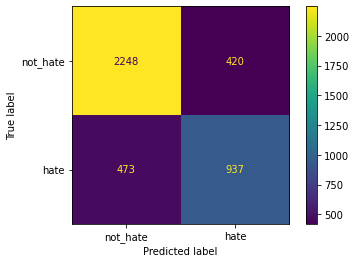

[0.84257871 0.66453901] [0.82616685 0.69049374] [0.83429208 0.6772678 ]
Validation accuracy: 0.7810201078960275

Training complete!


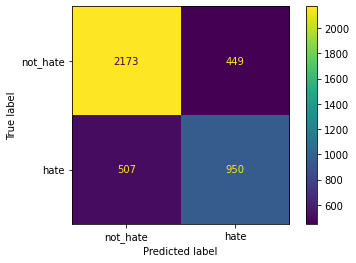

Test accuracy: 0.7656288305957343


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▅▅▄▄▄▅▄▂▅▄▆▃▆▃▂▂▅▄▅▅▂▂▂▄▄▆▃▃▁▁▂▁▁▂▃▁▂▅▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,▆▁▄█
batch,1529
batch_loss,0.00532
best_lr,2e-05
best_randomseed,42
best_val,0.78102


wandb: Agent Starting Run: td058m2f with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 782.7866135835648


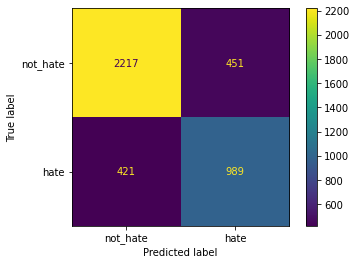

[0.83095952 0.70141844] [0.8404094  0.68680556] [0.83565775 0.69403509]
Validation accuracy: 0.7861696910250122

======== Epoch 2 / 4 ========
Training...
Total loss: 530.7003676434979


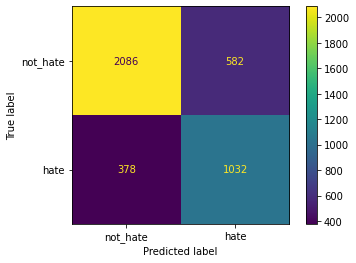

[0.78185907 0.73191489] [0.84659091 0.6394052 ] [0.81293843 0.68253968]
Validation accuracy: 0.7645904855321236

======== Epoch 3 / 4 ========
Training...
Total loss: 312.5281085591996


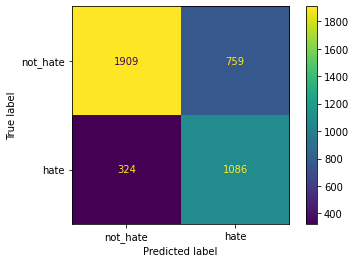

[0.71551724 0.77021277] [0.85490372 0.58861789] [0.77902469 0.66728111]
Validation accuracy: 0.7344286414909269

======== Epoch 4 / 4 ========
Training...
Total loss: 184.8437136276625


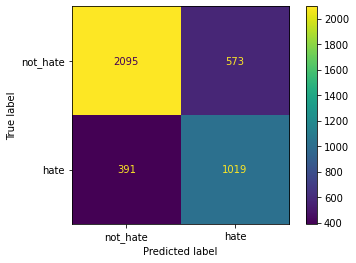

[0.78523238 0.72269504] [0.84271923 0.64007538] [0.81296081 0.67888075]
Validation accuracy: 0.7636096125551741

Training complete!


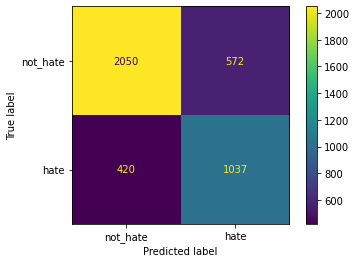

Test accuracy: 0.7568031380240255


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▅▅▅▄▄▅▄▃▆▅▇▂▇▅▃▂▆▆▃▄▁▂▂▂▄▅▂▃▂▁▂▂▄▂▂▁▁▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
val_acc,█▅▁▅
batch,1529
batch_loss,0.00379
best_lr,3e-05
best_randomseed,37
best_val,0.78617


wandb: Agent Starting Run: 1mcsrixz with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 763.3186732530594


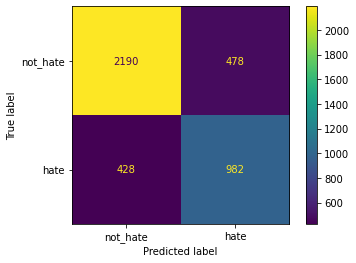

[0.82083958 0.6964539 ] [0.83651642 0.67260274] [0.82860386 0.68432056]
Validation accuracy: 0.7778322707209416

======== Epoch 2 / 4 ========
Training...
Total loss: 516.3137684501708


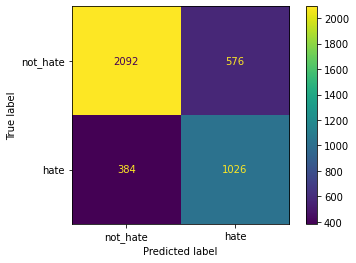

[0.78410795 0.72765957] [0.84491115 0.64044944] [0.81337481 0.6812749 ]
Validation accuracy: 0.7645904855321236

======== Epoch 3 / 4 ========
Training...
Total loss: 301.7574274656363


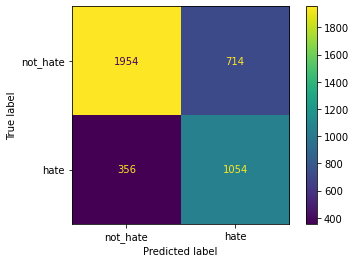

[0.73238381 0.74751773] [0.84588745 0.59615385] [0.78505424 0.66331026]
Validation accuracy: 0.7376164786660128

======== Epoch 4 / 4 ========
Training...
Total loss: 182.25922871610965


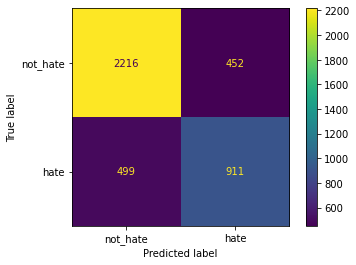

[0.83058471 0.64609929] [0.81620626 0.66837858] [0.82333271 0.65705013]
Validation accuracy: 0.76679744973026

Training complete!


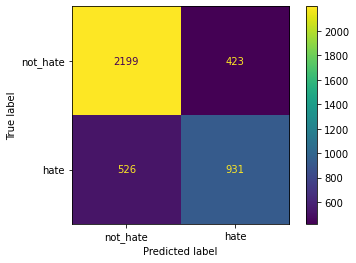

Test accuracy: 0.7673449374846776


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▅▅▃▃▄▄▅▂▅▃▆▂▆▂▂▂▄▅▃▃▂▁▁▂▅█▃▂▁▁▁▁▁▁▁▁▂▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
val_acc,█▆▁▆
batch,1529
batch_loss,0.00184
best_lr,3e-05
best_randomseed,69
best_val,0.77783


wandb: Agent Starting Run: sesrncdm with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 768.7629630342126


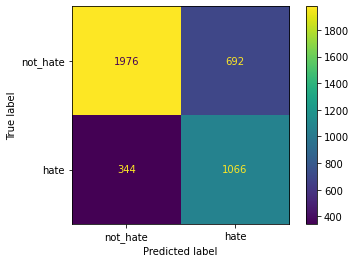

[0.74062969 0.75602837] [0.85172414 0.60637088] [0.79230152 0.6729798 ]
Validation accuracy: 0.7459538989700834

======== Epoch 2 / 4 ========
Training...
Total loss: 517.6112534012645


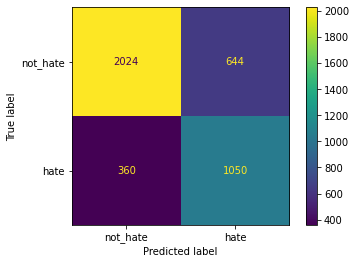

[0.75862069 0.74468085] [0.84899329 0.61983471] [0.80126683 0.67654639]
Validation accuracy: 0.7538008827856792

======== Epoch 3 / 4 ========
Training...
Total loss: 307.90661624842323


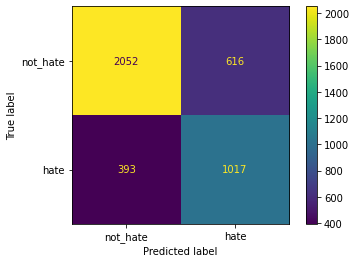

[0.76911544 0.7212766 ] [0.8392638  0.62278016] [0.80265989 0.66841932]
Validation accuracy: 0.7525747915644924

======== Epoch 4 / 4 ========
Training...
Total loss: 166.3420430632541


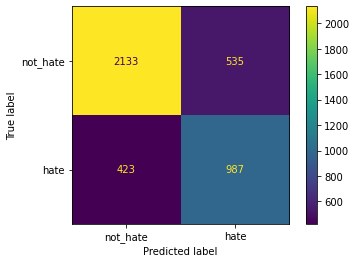

[0.79947526 0.7       ] [0.83450704 0.64848883] [0.81661562 0.67326057]
Validation accuracy: 0.7650809220205983

Training complete!


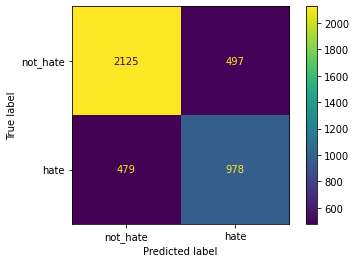

Test accuracy: 0.760725668055896


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,█▆▆▄▃▄▅▅▂▆▄▇▂▆▄▂▃▅▃▃▆▄▁▁▃▅▅▂▃▁▁▁▂▁▁█▁▁▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,▁▄▃█
batch,1529
batch_loss,0.01269
best_lr,3e-05
best_randomseed,42
best_val,0.76508


wandb: Agent Starting Run: d3eb2psm with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 816.3380343429744


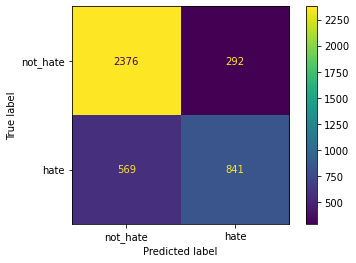

[0.89055472 0.5964539 ] [0.80679117 0.74227714] [0.84660609 0.66142352]
Validation accuracy: 0.7888670917116234

======== Epoch 2 / 4 ========
Training...
Total loss: 576.932782266289


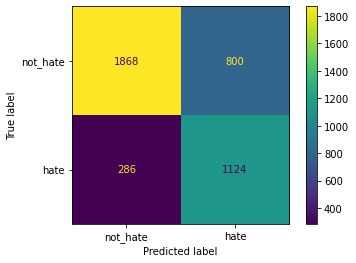

[0.70014993 0.79716312] [0.86722377 0.58419958] [0.77478225 0.67426515]
Validation accuracy: 0.7336929867582148

======== Epoch 3 / 4 ========
Training...
Total loss: 362.9186657287646


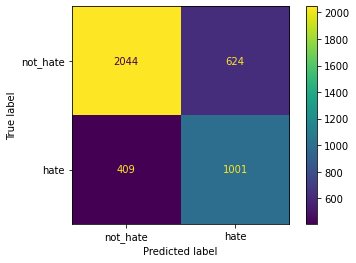

[0.76611694 0.70992908] [0.83326539 0.616     ] [0.79828159 0.65963756]
Validation accuracy: 0.7466895537027954

======== Epoch 4 / 4 ========
Training...
Total loss: 241.8365302339662


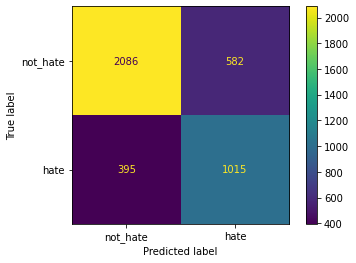

[0.78185907 0.71985816] [0.84079    0.63556669] [0.81025442 0.67509145]
Validation accuracy: 0.7604217753800883

Training complete!


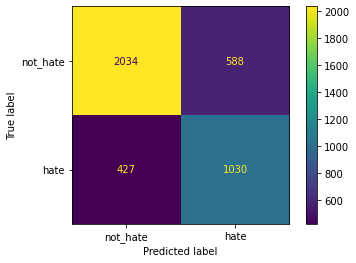

Test accuracy: 0.7511645011032115


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▆▅▅▃▃▄▃▆▂▆▄▅▂█▃▃▂▄▆▃▃▁▅▁▃▇▄▆▄▁▁▁▁▂▂▅▁▄▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
val_acc,█▁▃▄
batch,1529
batch_loss,0.00461
best_lr,4e-05
best_randomseed,37
best_val,0.78887


wandb: Agent Starting Run: o4v4v951 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 775.9908189699054


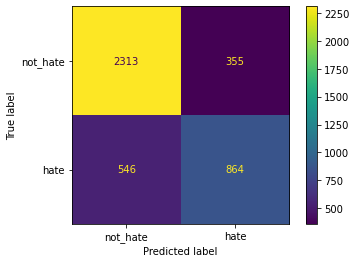

[0.86694153 0.61276596] [0.80902413 0.70877769] [0.83698209 0.65728414]
Validation accuracy: 0.7790583619421285

======== Epoch 2 / 4 ========
Training...
Total loss: 557.188990727067


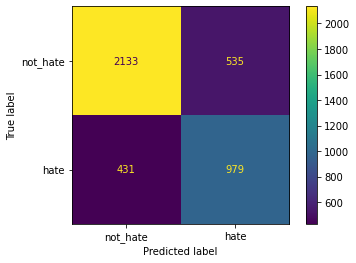

[0.79947526 0.69432624] [0.83190328 0.64663144] [0.81536697 0.66963064]
Validation accuracy: 0.7631191760666993

======== Epoch 3 / 4 ========
Training...
Total loss: 369.85870596114546


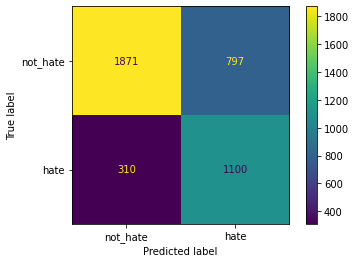

[0.70127436 0.78014184] [0.85786337 0.57986294] [0.77170551 0.66525552]
Validation accuracy: 0.72854340362923

======== Epoch 4 / 4 ========
Training...
Total loss: 228.6688231138396


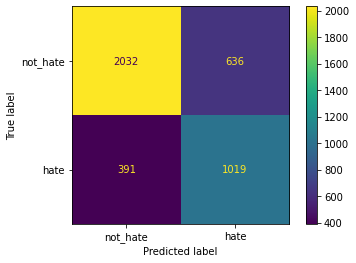

[0.76161919 0.72269504] [0.8386298  0.61570997] [0.79827146 0.66492659]
Validation accuracy: 0.7481608631682197

Training complete!


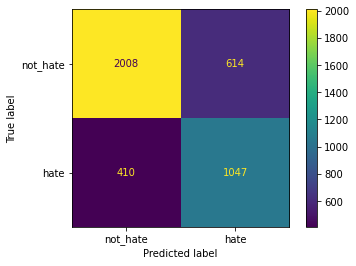

Test accuracy: 0.7489580779602844


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▇▆▆▄▃▃▆▄▃▆▄▆▁█▄▃▂▅▃▃▅▁▃▃▄▅▅▇▃▃▂▁▁▁▄▂▁▁▂▃
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,█▆▁▄
batch,1529
batch_loss,0.0225
best_lr,4e-05
best_randomseed,69
best_val,0.77906


wandb: Agent Starting Run: 2j5jqij6 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 777.1005722209811


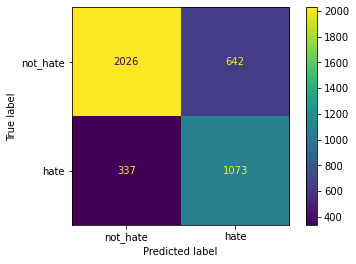

[0.75937031 0.76099291] [0.85738468 0.62565598] [0.80540648 0.68672   ]
Validation accuracy: 0.7599313388916136

======== Epoch 2 / 4 ========
Training...
Total loss: 535.7744134413078


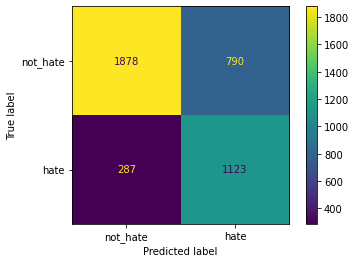

[0.70389805 0.7964539 ] [0.86743649 0.58703607] [0.77715705 0.67589528]
Validation accuracy: 0.7358999509563512

======== Epoch 3 / 4 ========
Training...
Total loss: 324.4413092969917


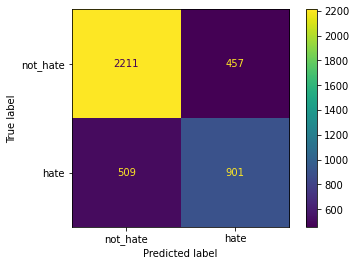

[0.82871064 0.63900709] [0.81286765 0.6634757 ] [0.82071269 0.65101156]
Validation accuracy: 0.7631191760666993

======== Epoch 4 / 4 ========
Training...
Total loss: 195.5609084010939


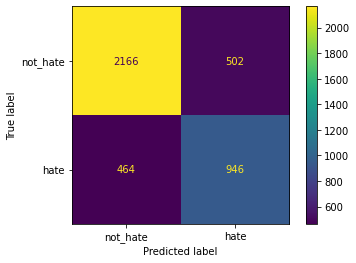

[0.81184408 0.67092199] [0.82357414 0.65331492] [0.81766704 0.6620014 ]
Validation accuracy: 0.7631191760666993

Training complete!


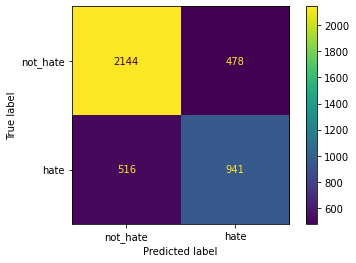

Test accuracy: 0.7563128217700417


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█
batch_loss,▇▅▇▄▃▃▅▅▂▆▄█▂▅▂▂▂▅▃▄▄▁▃▅▁▆█▃▇▂▁▂▁▂▄▄▁▁▁▃
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
val_acc,▇▁██
batch,1529
batch_loss,0.00158
best_lr,4e-05
best_randomseed,42
best_val,0.76312


In [ ]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")